In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter('ignore')
import time
import random
from PIL import Image
import glob
import torch
import re
from IPython.display import display
import os
import pickle
from tqdm.autonotebook import tqdm
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
from classes.embedder import Embedder
from classes.milvus_connector import MilvusConnector
from classes.utils import display_results, load_or_save_model
from dotenv import load_dotenv
load_dotenv();

2024-12-04 01:44:52.981524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 01:44:52.994124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 01:44:53.009670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 01:44:53.014234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 01:44:53.025961: I tensorflow/core/platform/cpu_feature_guar

# Models for embedding

In [3]:
clip_ml = load_or_save_model(os.path.join(os.environ.get("MODELS_DIR"), 'clip_ml.model'), 'clip-ViT-B-32-multilingual-v1')
clip = load_or_save_model(os.path.join(os.environ.get("MODELS_DIR"), 'clip.model'), 'clip-ViT-B-32')

INFO: Loading model from models/clip_ml.model...
INFO: Loading model from models/clip.model...


In [6]:
embedder = Embedder(base_model=clip, ml_model=clip_ml)

# Loading the images

In [27]:
IMAGES_FOLDER_PATH = os.environ.get("IMAGES_DIR")

In [29]:
images = []
for image in os.listdir(IMAGES_FOLDER_PATH):
    path = os.path.join(IMAGES_FOLDER_PATH, image)
    images.append({
        'path': path,
        'image': Image.open(path),
        'embedding': None
    })

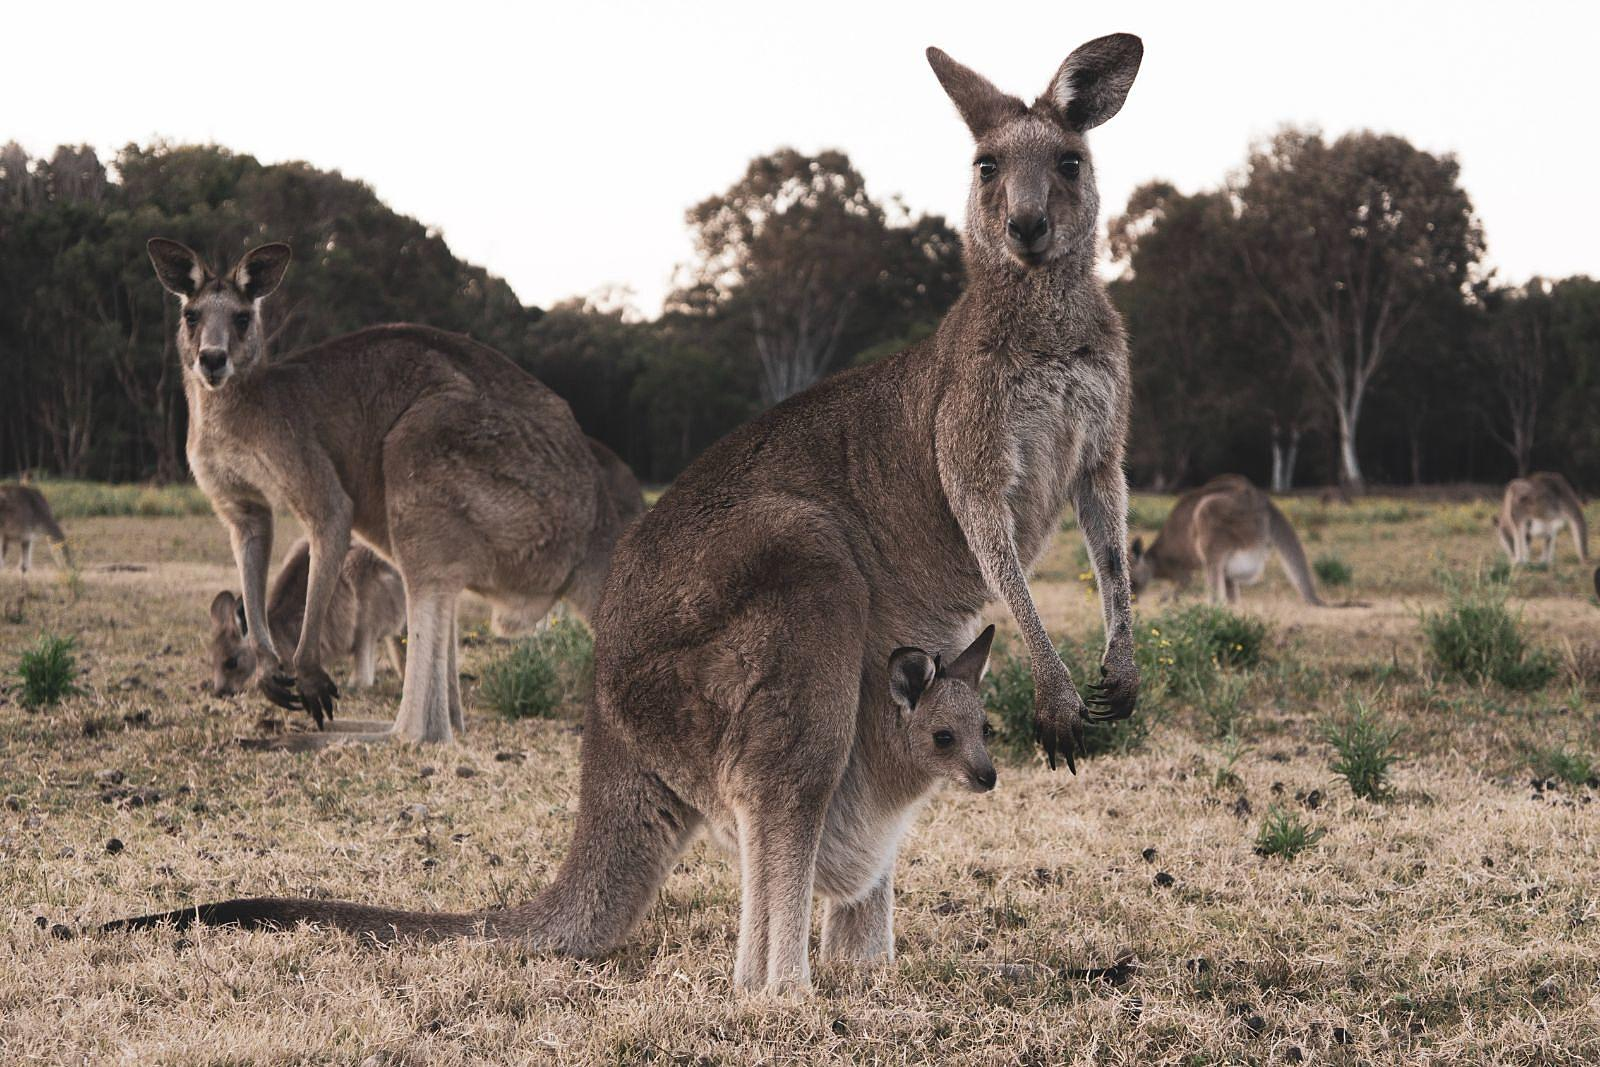

In [30]:
images[2]['image']

# Inserting into milvus

In [10]:
img_fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='path', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, dim=512)
]

with MilvusConnector() as connector:
    connector.create_collection('images', img_fields, remove_if_exists=True)

INFO: Existing collection 'images' dropped.
INFO: Collection 'images' created successfully.


In [11]:
with MilvusConnector() as connector:
    batch = []
    for img in images:
        img['embedding'] = embedder.embed_images(img['image']).to('cpu').tolist()[0]
        batch.append({'path': img['path'], 'embedding': img['embedding']})
    connector.insert(batch, collection_name='images')

INFO: Inserted 12 entries into images (Batch 1/1)


## TOP K

In [18]:
QUERY = 'fish'

In [19]:
with MilvusConnector() as connector:
    res = connector.search_topk(embedder.embed_sentences(QUERY), output_field='path', k=4)

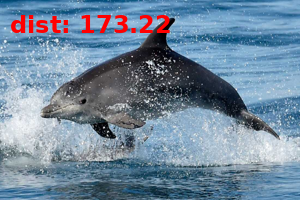

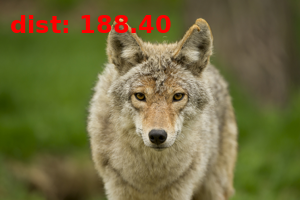

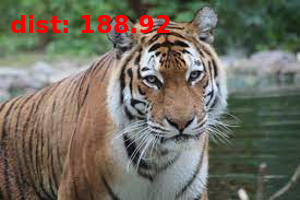

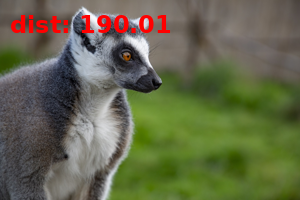

In [20]:
display_results(res)

# Threshold search

In [23]:
with MilvusConnector() as connector:
    res = connector.search_threshold(embedder.embed_sentences(QUERY), output_field='path', threshold=195)

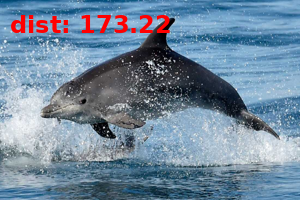

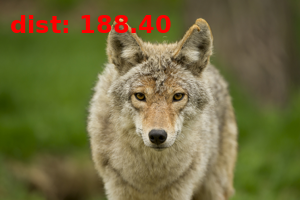

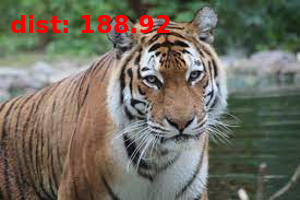

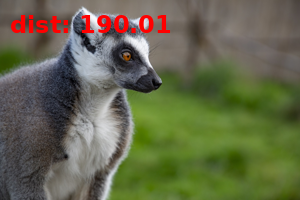

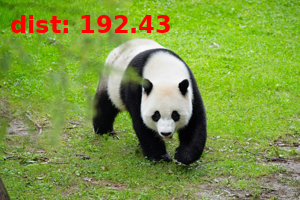

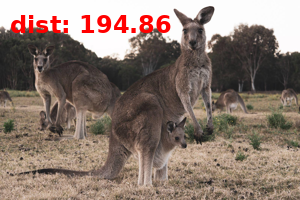

In [24]:
display_results(res)

# Search with another image

In [25]:
with MilvusConnector() as connector:
    res = connector.search_threshold(embedder.embed_images(images[2]['image']), output_field='path', threshold=200)

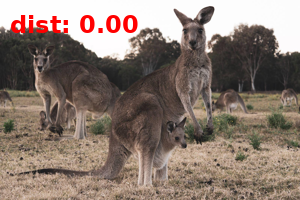

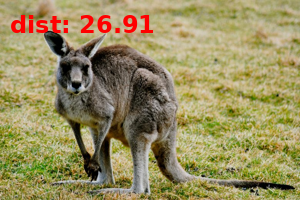

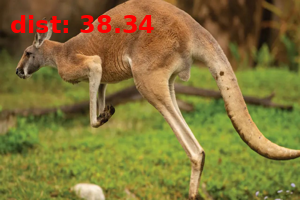

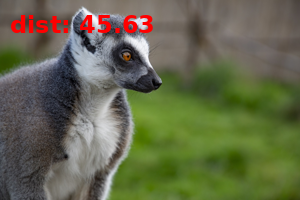

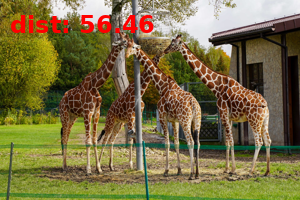

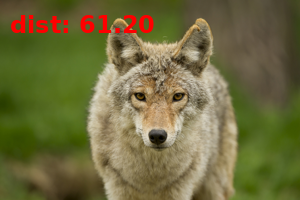

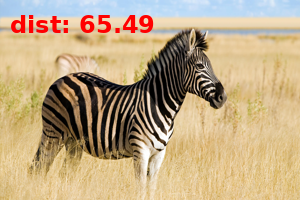

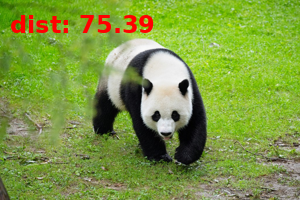

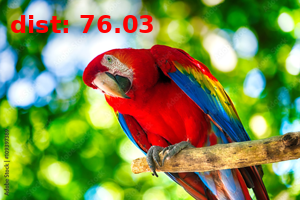

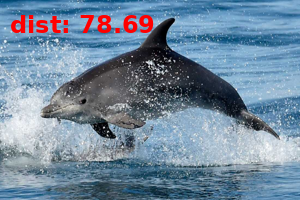

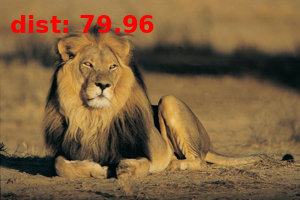

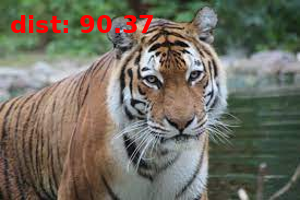

In [26]:
display_results(res)